In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'ssm_with_metadata_2017_03_13.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'samesex_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

#framing_annotations = misc.read_article_data(os.path.join(data_dir, 'samesex_framing_annotations.csv'), first_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 7595 articles
Loaded tone annotations for 3230 articles
Last date =  2012-12-31 00:00:00


In [5]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)

Grouped data into 84 periods


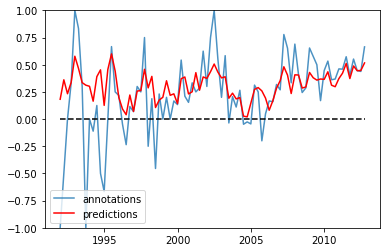

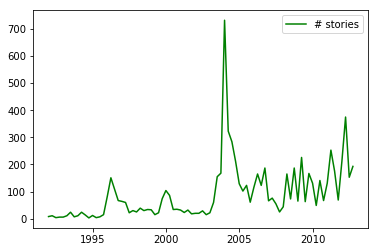

In [34]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

grouped = misc.compute_entropy(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

grouped['tone_a'] = grouped_tone_annotations['tone']
#grouped['entropy_a'] = grouped_framing_annotations['entropy']

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone, 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
ax.legend(loc='lower left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.stories, c='green', label='# stories')
ax.legend()

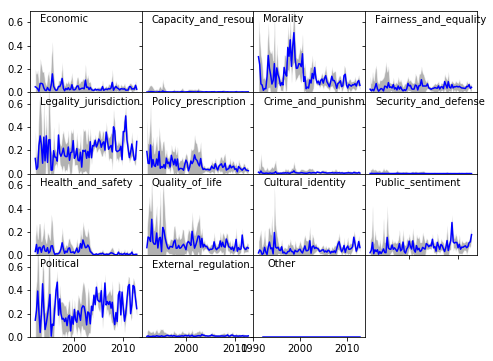

In [22]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.7)

1992
Loaded 164 polls
        Issue    Varname   House     Date  Topic  Subcode    L1    L2   L3  \
257  same-sex    HOMOMAR  GALLUP  3/15/96    150      151  27.0   0.0  0.0   
62   same-sex     GAYWED    PSRA  5/31/96    150      151   6.0  21.0  0.0   
248  same-sex      ABCCU   ABCWP   8/1/96    150      151  37.0   0.0  0.0   
258  same-sex    HOMOMAR  GALLUP   2/8/99    150      151  35.0   0.0  0.0   
150  same-sex  GAYWEDFOX     FOX  1/12/00    150      151  19.0  24.0  0.0   

      L4    ...     ABCCU  PSGAYUN  GAYWEDFOX  ABCBAN  MARHOMO  GAYMAR BANMAR  \
257  0.0    ...         0        0          0       0        0       0      0   
62   0.0    ...         0        0          0       0        0       0      0   
248  0.0    ...         1        0          0       0        0       0      0   
258  0.0    ...         0        0          0       0        0       0      0   
150  0.0    ...         0        0          1       0        0       0      0   

     GAYAMEND  CIVUNIO

(<matplotlib.figure.Figure at 0x7f21dfcb89d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f21dfc4b290>)

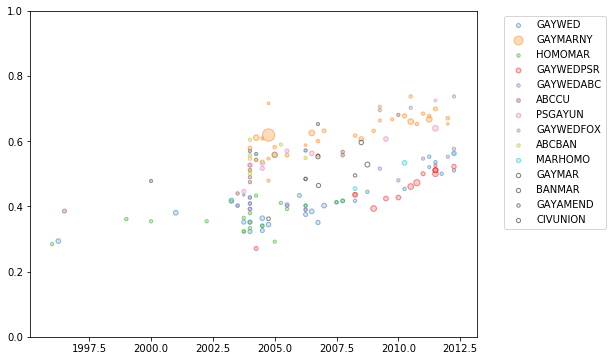

In [23]:
reload(misc)

filename = 'samesex_marriage_polls.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
# drop one poll that seems redundant (with a seeming mistake)
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=False)

In [24]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
grouped['salient'] = grouped.apply(lambda row: int(row['stories'] >= 350), axis=1)

# add in interactions
grouped['toneXstories'] = grouped['tone'] * grouped['stories']
# between tone and the "salient" variable
grouped['toneXsalient'] = grouped['tone'] * grouped['salient']
# between tone and the "entropy" variable
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

grouped['toneXstoriesXentropy'] = grouped['toneXstories'] * grouped['entropy']

grouped['toneXlogStories'] = grouped['tone'] * grouped['logStories']

#grouped['aToneXstories'] = grouped['tone_a'] * grouped['stories']
#grouped['aToneXaEntropy'] = grouped['tone_a'] * grouped['entropy_a']

In [25]:
reload(misc)

# grab tone and prev_mood data for each poll
tones = []
prev_moods = []
stories = []
entropies = []
for i in polls.index:
    if group_by == 'month':
        period = polls.loc[i]['p_month']
    elif group_by == 'quarter':
        period = polls.loc[i]['p_quarter']
    tones.append(grouped.loc[period]['tone'])
    #prev_moods.append(mood.loc[period-1]['prev_mood'])
    stories.append(grouped.loc[period]['stories'])
    entropies.append(grouped.loc[period]['entropy'])
polls['tone'] = tones
#polls['prev_mood'] = prev_moods
#polls['prev_transformed'] = np.log(polls.prev_mood / (1 - polls.prev_mood))
polls['stories'] = stories
polls['logStories'] = np.log(stories) - np.mean(np.log(stories))
polls['entropy'] = entropies
polls['toneXstories'] = polls['tone'] * polls['stories']
polls['toneXlogStories'] = polls['tone'] * polls['logStories']
polls['toneXentropy'] = polls['tone'] * polls['entropy']

polls = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30, include_tone=True, include_frames=True)


In [26]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [27]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, polls.question.values[i]] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
   ABCCU	9
 PSGAYUN	9
GAYWEDFOX	8
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1


''

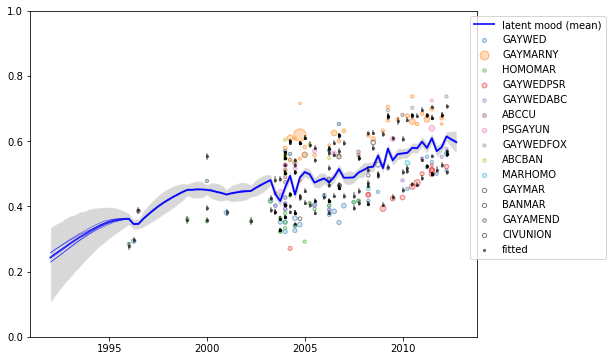

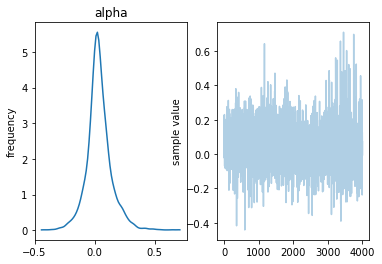

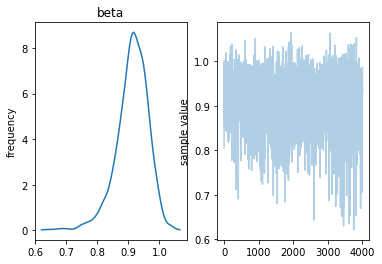

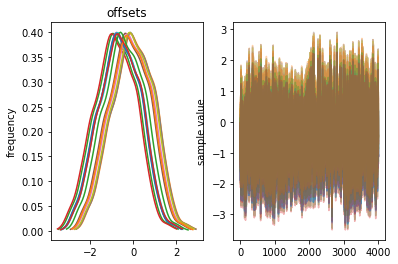

In [33]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

fit.plot('alpha')
fit.plot('beta')
#fit.plot('gamma')
fit.plot('offsets')

""

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
   ABCCU	9
 PSGAYUN	9
GAYWEDFOX	8
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 4
log_p_new: -602.95


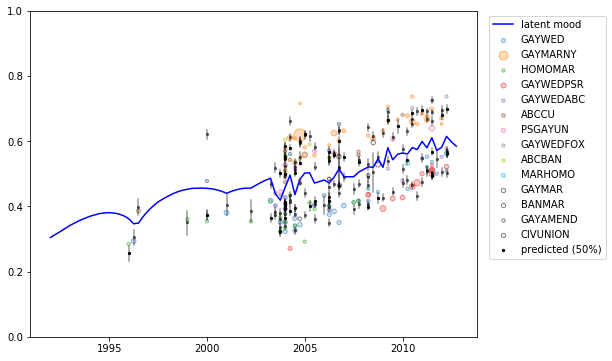

In [35]:
fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

In [36]:
# EXTEND MODEL with weights and covariates

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int K; // number of covariates
  row_vector[K] X[T];  // covariates: shape of matrix[T, K]
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
  vector[K] gamma; // weights on covariates
  real gamma_mean;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);
  gamma_mean ~ normal(0, 1);
  for (k in 1:K)
    gamma[k] ~ normal(gamma_mean, beta_var);  // use same variance as weight on previous mu

  p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0 + X[1] * gamma, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1] + X[j] * gamma, sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
   ABCCU	9
 PSGAYUN	9
GAYWEDFOX	8
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
(84, 5)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.12477554 -0.01563211  0.2690999  -0.14575008  0.11302702]
[ 0.36022517  0.05763215  0.16509837  0.2132584   0.18800375]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.16530751  0.01407928  0.32640778  0.00237676  0.14089508]
[ 0.34455152  0.06963946  0.20221399  0.20596927  0.19580021]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.08098395  0.01768494  0.19163182 -0.02015159  0.09258928]
[ 0.2586103   0.05240842  0.14964046  0.15727582  0.14145735]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.10115059  0.0373662   0.14808709  0.03135563  0.08968837]
[ 0.22921537  0.04564701  0.13140428  0.12877019  0.12851379]
fold 4
[ 0.1582642  -0.01335844  0.26886037 -0.06661063  0.12649803]
[ 0.3477005   0.07127558  0.20422545  0.22383536  0.19663359]
log_p_new: -588.84


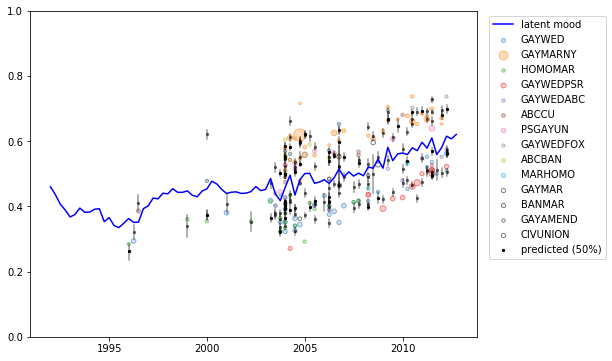

In [37]:
# TONE, logSTORIES, TONE x logSTORIES, ENTROPY, TONE x ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, toneXlogStories, entropy, toneXentropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive